In [1]:
#imports
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy


#Load data and Visualize



In [2]:
# Load the data
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True, as_supervised= True)

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incomplete4CMZOQ/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


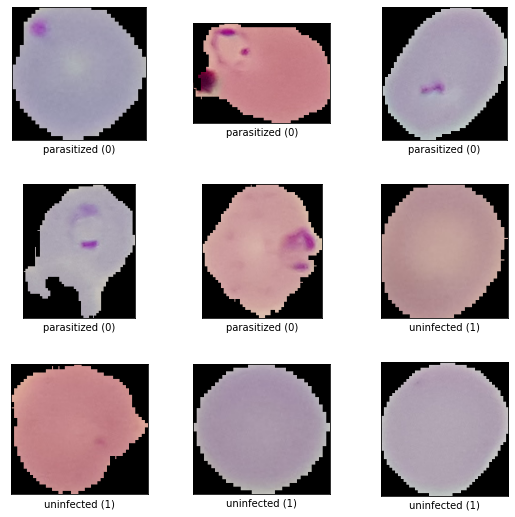

In [3]:
#show example

viz = tfds.visualization.show_examples(ds, info)

In [4]:
# # extract labels and features


# train_images = []
# train_labels = []

# for i in ds:
#   train_images.append(i[0])
#   train_labels.append(i[1])

# #find minimum of picture dimensions

# h = []
# w = []

# for i in train_images:
#   h.append(i.shape[0])
#   w.append(i.shape[1])

# width = np.min(w) #46
# height = np.min(h) #40


In [5]:
# reshape data to the smallest size 40x46. We use image.resize as to not add more zero padding. Empirically works quite well.
# we standardize the images, such that our network does have standardized values to train on an can generalize better


height = 40
width = 46

data = ds.map(lambda sample,label: (tf.image.resize(sample, [height,width]), label))
data = data.map(lambda sample,label: (tf.image.per_image_standardization(sample), label))
data = data.map(lambda sample,label: (tf.cast(sample, tf.float32), tf.cast(label,tf.int32)))

In [6]:
#one hot encode labels
data = data.map(lambda sample, label: (sample, tf.one_hot(label,2)))



In [7]:
# Finish up the pipeline with prefetching, caching, batching and shuffeling


data = data.cache()
data = data.prefetch(tf.data.experimental.AUTOTUNE)



# Split the data into test and training data (80-20)
batch_size = 256

train_size = int(27558 * 0.8)
data_train = data.take(train_size)
data_train = data_train.batch(batch_size)
data_train = data_train.shuffle(buffer_size=batch_size)
data_test = data.skip(train_size)
data_test = data_test.batch(batch_size)

#Model
Create modela CNN

In [8]:
# 0.9615

# Clear previous keras data
tf.keras.backend.clear_session()

#mix of pooling layers tio reduce depth and convolutional layers to increase the depth
#softmax activation in the end to classify our onehot label
epochs = 20
lr = 0.0005
model = tf.keras.models.Sequential([tf.keras.layers.Reshape((40,46,3)),
                                    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", input_shape=(40,46,3)),
                                    tf.keras.layers.MaxPooling2D(2, strides=1),
                                    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, strides=1),
                                    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, strides=1),
                                    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu"),
                                    tf.keras.layers.GlobalAveragePooling2D(),
                                    tf.keras.layers.Dense(512, activation=tf.keras.activations.relu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
                                    tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)])





#Training 
Train the model

In [ ]:
#Adam is one of the best optimizers
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(loss="categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])

# Get the initial loss and accuracies for both data sets
init_train_metrics = model.evaluate(data_train, verbose=0)
init_test_metrics = model.evaluate(data_test, verbose=0)

# Hide warnings
tf.get_logger().setLevel("ERROR")

history = model.fit(data_train, validation_data = data_test, epochs=epochs, shuffle=True)

Epoch 1/20
87/87 [==============================] - 19s 222ms/step - loss: 0.4263 - accuracy: 0.7867 - val_loss: 0.2043 - val_accuracy: 0.9376
Epoch 2/20
87/87 [==============================] - 19s 223ms/step - loss: 0.1806 - accuracy: 0.9412 - val_loss: 0.1617 - val_accuracy: 0.9514
Epoch 3/20
87/87 [==============================] - 20s 228ms/step - loss: 0.1550 - accuracy: 0.9495 - val_loss: 0.1461 - val_accuracy: 0.9534
Epoch 4/20
87/87 [==============================] - 20s 233ms/step - loss: 0.1411 - accuracy: 0.9530 - val_loss: 0.1456 - val_accuracy: 0.9505
Epoch 5/20
53/87 [=================>............] - ETA: 7s - loss: 0.1387 - accuracy: 0.9523


#Visualize
Visualize trainings process


In [ ]:
# Combine the losses and averages while training with the ones before training
train_loss = np.concatenate(([init_train_metrics[0]], history.history["loss"]))
train_acc = np.concatenate(([init_train_metrics[1]], history.history["accuracy"]))

test_loss = np.concatenate(([init_test_metrics[0]], history.history["val_loss"]))
test_acc = np.concatenate(([init_test_metrics[1]], history.history["val_accuracy"]))

# draw the loss plot
plt.figure()
line1, = plt.plot(train_loss)
line2, = plt.plot(test_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend((line1, line2), ("training", "test"))
plt.show()

# draw the accuracy plot
plt.figure()
line1, = plt.plot(train_acc)
line2, = plt.plot(test_acc)
line3, = plt.plot([0.95] * (epochs + 1))
line3.set_alpha(0.5)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend((line1, line2, line3), ("training", "test", "targeted accuracy"))
plt.show()

